<!-- # Imports -->

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Combining the Dataset

In [4]:
msn10 = pd.read_csv("data/msn_10_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn11 = pd.read_csv("data/msn_11_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn12 = pd.read_csv("data/msn_12_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn14 = pd.read_csv("data/msn_14_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn29 = pd.read_csv("data/msn_29_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn37 = pd.read_csv("data/msn_37_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn53 = pd.read_csv("data/msn_53_fuel_leak_signals_preprocessed.csv", delimiter=';')

In [5]:
combined = pd.concat([msn10, msn11, msn12, msn14, msn29, msn37, msn53])

In [6]:
# Setting index as datetime
combined['UTC_TIME'] = pd.to_datetime(combined['UTC_TIME'])
combined = combined.set_index("UTC_TIME")

In [7]:
# Dropping Duplicates
combined = combined.drop_duplicates()

# Dropping Null Roles
combined = combined.dropna(subset=combined.columns)

In [8]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 894472 entries, 2014-09-19 09:08:37 to 2018-04-22 14:56:31
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FUEL_USED_2         894472 non-null  float64
 1   FUEL_USED_3         894472 non-null  float64
 2   FUEL_USED_4         894472 non-null  float64
 3   FW_GEO_ALTITUDE     894472 non-null  float64
 4   VALUE_FOB           894472 non-null  float64
 5   VALUE_FUEL_QTY_CT   894472 non-null  float64
 6   VALUE_FUEL_QTY_FT1  894472 non-null  float64
 7   VALUE_FUEL_QTY_FT2  894472 non-null  float64
 8   VALUE_FUEL_QTY_FT3  894472 non-null  float64
 9   VALUE_FUEL_QTY_FT4  894472 non-null  float64
 10  VALUE_FUEL_QTY_LXT  894472 non-null  float64
 11  VALUE_FUEL_QTY_RXT  894472 non-null  float64
 12  FLIGHT_PHASE_COUNT  894472 non-null  float64
 13  FUEL_USED_1         894472 non-null  float64
 14  Flight              894472 non-null  float64
 15  

### Identifying Unique Flight Instances

In [9]:
# Identify Different Flights within the same flight number
# ========================================================

# Identify when a new flight starts (FLIGHT_PHASE_COUNT resets within each Flight)
combined['NEW_FLIGHT'] = combined.groupby('Flight')['FLIGHT_PHASE_COUNT'].diff().lt(0)

# Assign a unique flight instance number per Flight
combined['FLIGHT_INSTANCE'] = combined.groupby('Flight')['NEW_FLIGHT'].cumsum()

# New column to identify unique flights
combined['FLIGHT_ID'] = combined['Flight'].astype(str) + "_" + combined['FLIGHT_INSTANCE'].astype(str)

In [10]:
# This will be used later
# Find the initial fuel value for each flight instance
combined['START_FOB'] = combined.groupby('FLIGHT_ID')['VALUE_FOB'].transform('first')

### Filtering out for Cruise Phase

In [11]:
# Filter out only for flight phase 8 - Cruise
combined = combined[combined["FLIGHT_PHASE_COUNT"]==8.0]

In [12]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376554 entries, 2015-07-21 03:51:31 to 2018-04-22 11:45:45
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FUEL_USED_2         376554 non-null  float64
 1   FUEL_USED_3         376554 non-null  float64
 2   FUEL_USED_4         376554 non-null  float64
 3   FW_GEO_ALTITUDE     376554 non-null  float64
 4   VALUE_FOB           376554 non-null  float64
 5   VALUE_FUEL_QTY_CT   376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1  376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2  376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3  376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4  376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT  376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT  376554 non-null  float64
 12  FLIGHT_PHASE_COUNT  376554 non-null  float64
 13  FUEL_USED_1         376554 non-null  float64
 14  Flight              376554 non-null  float64
 15  

# Feature Engineering

**THINGS TO CONSIDER**

| **Column Name** | **Description** |
| ----------- | ----------- |
| `VALUE_FOB` | Fuel on Board |
| `VALUE_FUEL_QTY_CT` | Central Tank |
| `VALUE_FUEL_QTY_FT1` | Fuel Quantity Feed Tank 1 (Engine 1) |
| `VALUE_FUEL_QTY_FT2` | Fuel Quantity Feed Tank 2 (Engine 2) |
| `VALUE_FUEL_QTY_FT3` | Fuel Quantity Feed Tank 3 (Engine 3) |
| `VALUE_FUEL_QTY_FT4` | Fuel Quantity Feed Tank 1 (Engine 4) |
| `VALUE_FUEL_QTY_LXT` | Fuel Quantity Transfer Tank Left |
| `VALUE_FUEL_QTY_RXT` | Fuel Quantity Transfer Tank Right |
| `FUEL_USED_1` | Fuel Used (Engine 1) |
| `FUEL_USED_2` | Fuel Used (Engine 2) |
| `FUEL_USED_3` | Fuel Used (Engine 3) |
| `FUEL_USED_4` | Fuel Used (Engine 4) |

Based on typical Airbus engining, we can thus assume the following:

| **Column Name** | **Left vs Right Side**|
| ----------- | ----------- |
| `VALUE_FUEL_QTY_LXT` | Left Outer fuel Quantity |
| `VALUE_FUEL_QTY_FT1` | Left Inner Fuel Quanitity  |
| `VALUE_FUEL_QTY_FT2` | Left Inner Fuel Quantity |
| `VALUE_FUEL_QTY_RXT` | Right Outer Fuel Quantity |
| `VALUE_FUEL_QTY_FT3` | Right Inner Fuel Quantity |
| `VALUE_FUEL_QTY_FT4` | Right Inner Fuel Quantity |

Additionally, from our research:
- Fuel can be transfered from the outertanks to the inner tanks
- This transfer happens when the inner tanks meet a certain threshold of fuel quantity, triggering the transfer from outer to inner tanks
- Fuel can be transfer from the heavier side to the lighter side to maintain balance
- Pilot and crew can detect a fuel leak when:
    1. Fuel at any point is significantly less than the predicted quantity at that time
    2. Fuel flow indiciations are significantly hgher on one engine in comparison to the other
    3. There is a significant differece between the fuel quantities between tanks in the left and right wing
    4. There is a fuel imbalance of a certain threshold or more in a specific time periond (ie. 230kg or more difference within 30 minutes.)
    5. The rate of loss of fuel on board is significantly different from the rate of fuel used by engines


### Fuel Discrepancy

In [13]:
# Calculating Fuel Discrepancy
# ============================

# Sort by time
combined = combined.sort_index()

# Find the initial fuel value for each flight instance
combined['START_FOB'] = combined.groupby('FLIGHT_ID')['VALUE_FOB'].transform('first')

# Calculate the total fuel used
combined['TOTAL_FUEL_USED'] = combined['FUEL_USED_1'] + combined['FUEL_USED_2'] + combined['FUEL_USED_3'] + combined['FUEL_USED_4']

# Calcuate expected fuel on board
combined['EXPECTED_FOB'] = combined['START_FOB'] - combined['TOTAL_FUEL_USED']

# Find Fuel Discrepancy between expected value and current value
combined["FOB_DIFFERENCE"] = (combined['EXPECTED_FOB'] - combined['VALUE_FOB']).abs()

### Fuel Leak Rate

In [14]:
# Calculate the fuel leak rate

# Change in Fuel on Board (Actual)
combined['FOB_CHANGE'] = combined['VALUE_FOB'].diff()

# Expected Change based on fuel burned (negative because fuel is consumed)
combined['EXPECTED_FOB_CHANGE'] = -combined['TOTAL_FUEL_USED'].diff()  

# Fuel Leak Rate (If positive, actual fuel loss exceeds expected)
combined['FUEL_LEAK_RATE'] = combined['EXPECTED_FOB_CHANGE'] - combined['FOB_CHANGE']

# Handle first row NaN values after diff()
combined['FOB_CHANGE'] = combined['FOB_CHANGE'].fillna(0)
combined['EXPECTED_FOB_CHANGE'] = combined['EXPECTED_FOB_CHANGE'].fillna(0)
combined['FUEL_LEAK_RATE'] = combined['FUEL_LEAK_RATE'].fillna(0)


### Left Wing, Right Wing Discrepancy

In [15]:
# Total Fuel in Left and Right Wing
combined['TOTAL_FUEL_LW'] = (combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'])
combined['TOTAL_FUEL_RW'] = (combined['VALUE_FUEL_QTY_RXT'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'])

# Fuel Difference
combined['LW_RW_DIFF'] = (combined['TOTAL_FUEL_LW'] - combined['TOTAL_FUEL_RW']).abs()

### Discrepancy between given `VALUE_FOB` and our own calcuations of fuel on board `FUEL_IN_TANKS`

In [16]:
# Total amount of fuel in tanks
combined['FUEL_IN_TANKS'] = combined['VALUE_FUEL_QTY_CT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'] + combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_RXT']

# Difference between our calcuations and given calculations
combined['CALC_VALUE_FOB_DIFF'] =  combined['FUEL_IN_TANKS'] - combined['VALUE_FOB']

### Assumption: Intiial FOB should equate to the sum of the current Fuel on Board + Total Fuel Used

In [17]:
combined['START_FOB_VS_FOB_FUELUSED'] = combined['START_FOB'] - (combined['FUEL_IN_TANKS'] + combined['TOTAL_FUEL_USED'])

### Altitude Difference

In [18]:
combined['ALTITUDE_DIFF'] = combined['FW_GEO_ALTITUDE'].diff().fillna(0)     

# Exploratory Data Analysis (EDA)

### Fuel Discrepancy `FOB_DIFFERENCE`

In [19]:
combined['FOB_DIFFERENCE'].describe()

count    376554.000000
mean       2319.123071
std        2579.014153
min           0.095032
25%         629.768158
50%        2107.337891
75%        2800.655182
max       39858.523926
Name: FOB_DIFFERENCE, dtype: float64

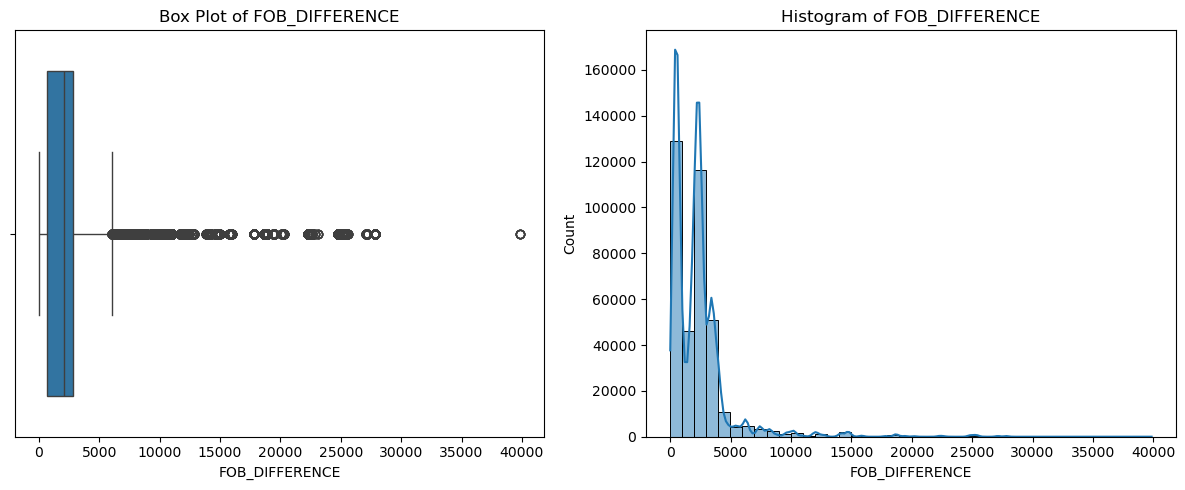

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['FOB_DIFFERENCE'], ax=axes[0])
axes[0].set_title('Box Plot of FOB_DIFFERENCE')

# Histogram
sns.histplot(combined["FOB_DIFFERENCE"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of FOB_DIFFERENCE')

plt.tight_layout()
plt.show()

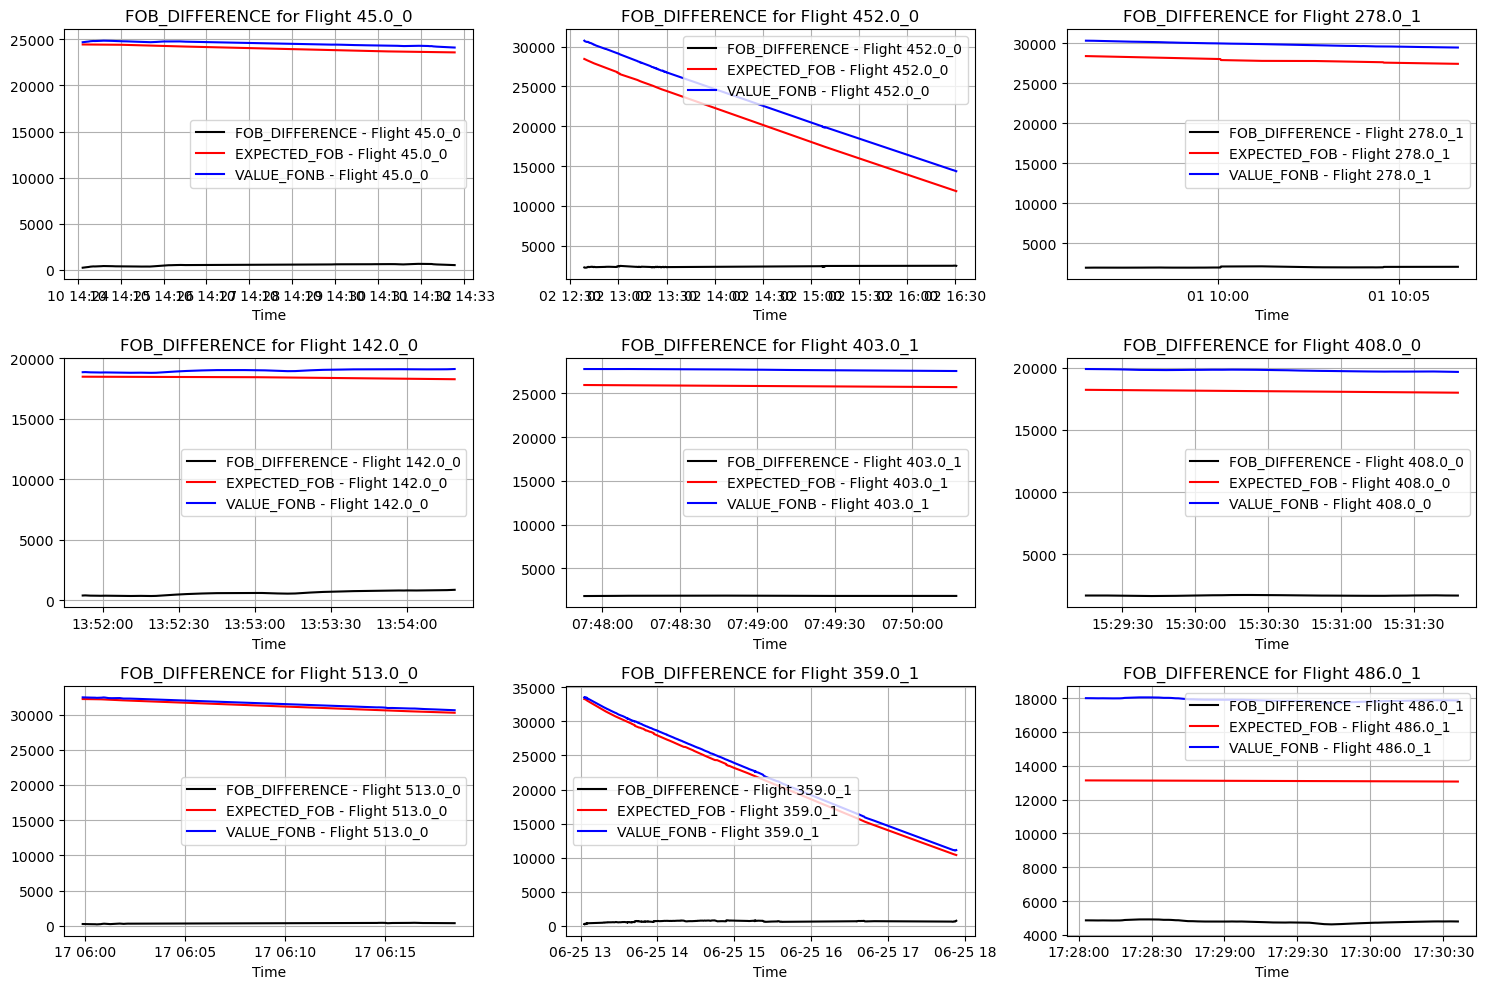

In [21]:
# Plotting FOB Difference in Unique Fights
# =======================================
flights_to_plot = np.random.choice(combined['FLIGHT_ID'].unique(), size=9, replace=False)

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    ax.plot(flight_data.index, flight_data['FOB_DIFFERENCE'], label=f'FOB_DIFFERENCE - Flight {flight}', color='black')
    ax.plot(flight_data.index, flight_data['EXPECTED_FOB'], label=f'EXPECTED_FOB - Flight {flight}', color='red')
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FONB - Flight {flight}', color='blue')

    ax.legend()
    
    ax.set_title(f'FOB_DIFFERENCE for Flight {flight}')
    ax.set_xlabel('Time')
    
    ax.grid(True)

plt.tight_layout()

plt.show()

### Fuel Leak Rate

In [22]:
combined['FUEL_LEAK_RATE'].describe()

count    376554.000000
mean          0.022704
std        1338.772003
min      -40346.235962
25%          -1.448242
50%          -0.219727
75%           1.458435
max       40406.729187
Name: FUEL_LEAK_RATE, dtype: float64

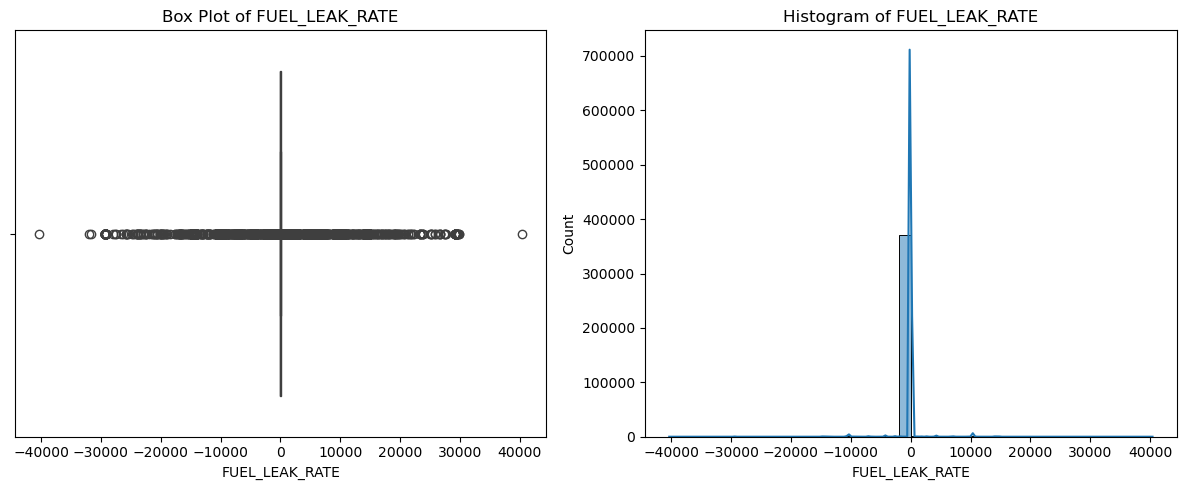

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['FUEL_LEAK_RATE'], ax=axes[0])
axes[0].set_title('Box Plot of FUEL_LEAK_RATE')

# Histogram
sns.histplot(combined["FUEL_LEAK_RATE"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of FUEL_LEAK_RATE')

plt.tight_layout()
plt.show()

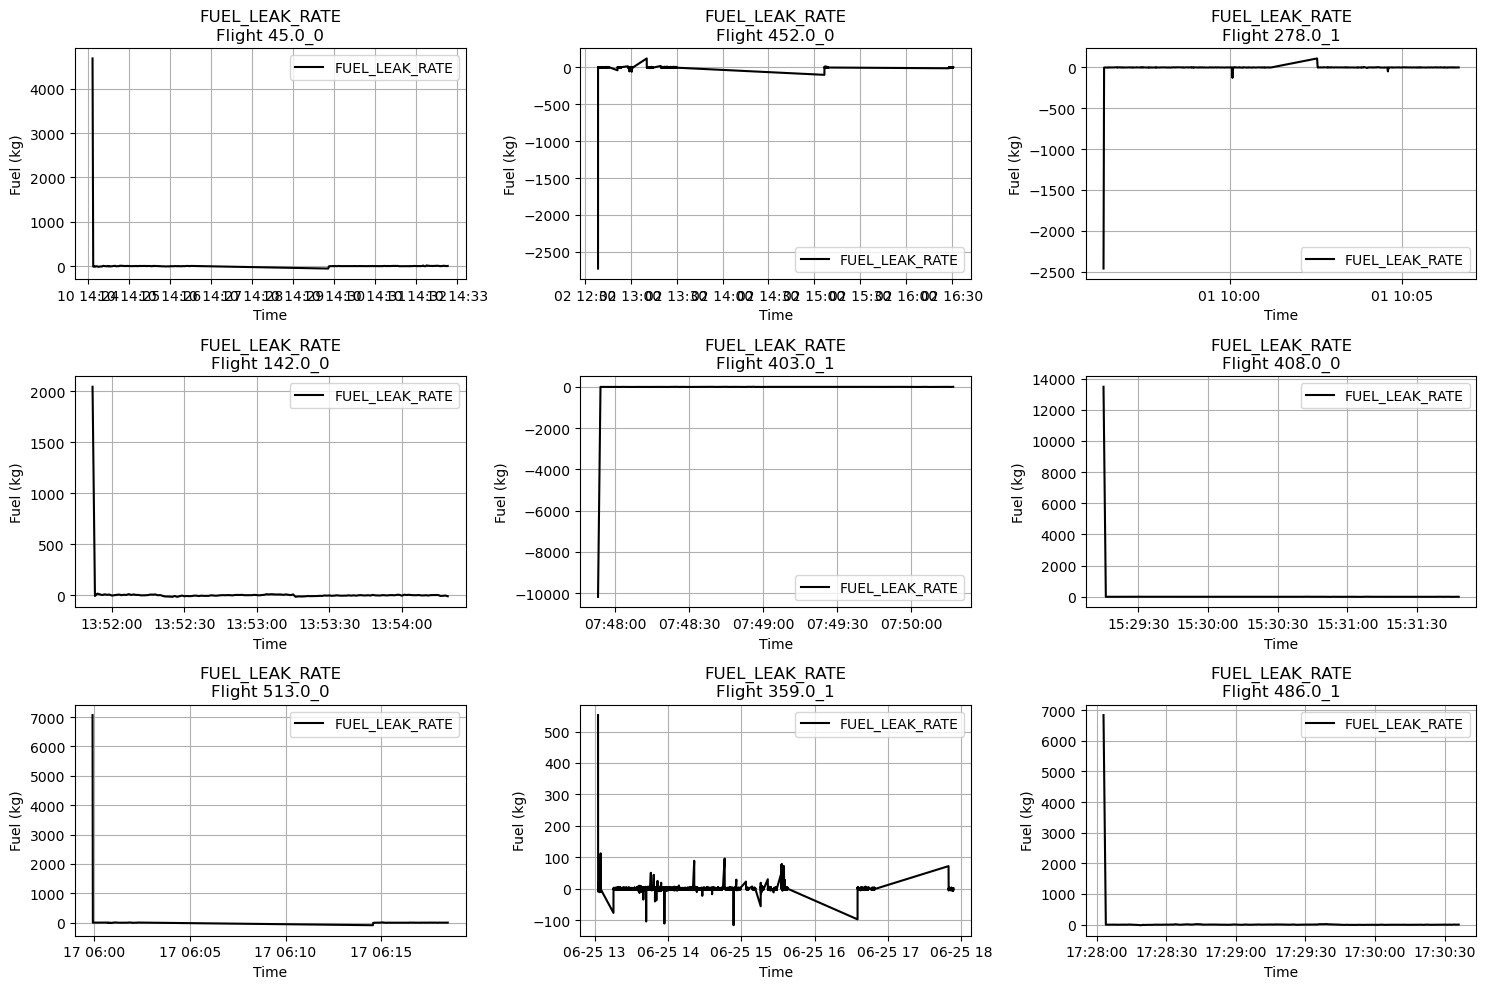

In [24]:
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Plot TOTAL_FUEL_RW vs TOTAL_FUEL_LW
    ax.plot(flight_data.index, flight_data['FUEL_LEAK_RATE'], label='FUEL_LEAK_RATE', color='black')
    
    ax.set_title(f'FUEL_LEAK_RATE\nFlight {flight}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Fuel (kg)')
    
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Left Wing, Right Wing Discrepancy

In [25]:
combined['LW_RW_DIFF'].describe()

count    376554.000000
mean        213.144720
std         217.250952
min           0.000000
25%          83.000000
50%         171.000000
75%         297.000000
max        5340.000000
Name: LW_RW_DIFF, dtype: float64

In [26]:
combined['TOTAL_FUEL_RW'].describe()

count    376554.000000
mean      11994.836255
std        3356.889396
min           0.000000
25%        9383.000000
50%       12151.000000
75%       15009.000000
max       18392.000000
Name: TOTAL_FUEL_RW, dtype: float64

In [27]:
combined['TOTAL_FUEL_LW'].describe()

count    376554.000000
mean      12063.996245
std        3350.684237
min           0.000000
25%        9493.000000
50%       12267.000000
75%       15064.000000
max       18656.000000
Name: TOTAL_FUEL_LW, dtype: float64

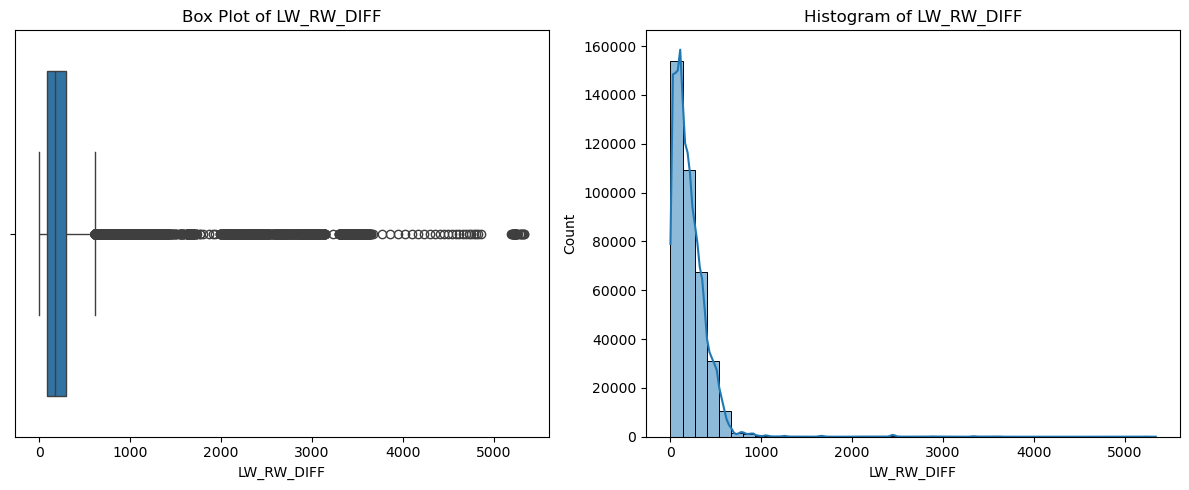

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['LW_RW_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of LW_RW_DIFF')

# Histogram
sns.histplot(combined["LW_RW_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of LW_RW_DIFF')

plt.tight_layout()
plt.show()

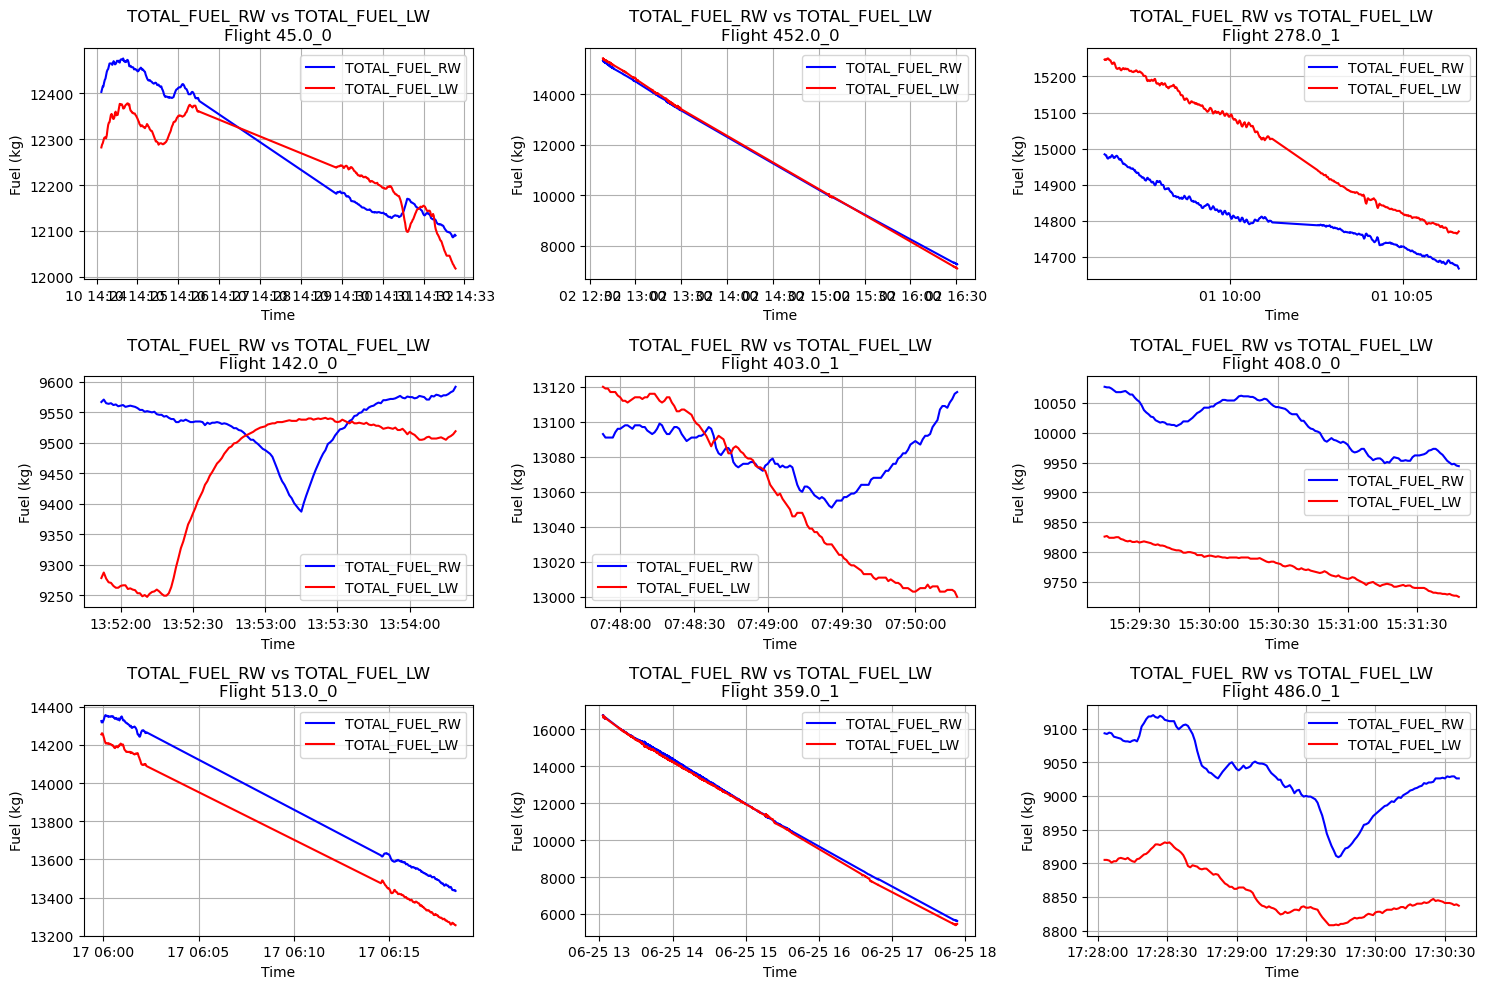

In [29]:
# Left Wing vs Right Wing Fuel Imbalance
# ======================================

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Plot TOTAL_FUEL_RW vs TOTAL_FUEL_LW
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_RW'], label='TOTAL_FUEL_RW', color='blue')
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_LW'], label='TOTAL_FUEL_LW', color='red')
    
    ax.set_title(f'TOTAL_FUEL_RW vs TOTAL_FUEL_LW\nFlight {flight}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Fuel (kg)')
    
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Discrepancy between given `VALUE_FOB` and our own calcuations of fuel on board `FUEL_IN_TANKS`

In [30]:
combined['VALUE_FOB'].describe()

count    376554.000000
mean      24758.041319
std        7745.473622
min           0.000000
25%       18879.250000
50%       24450.000000
75%       30285.000000
max       48403.000000
Name: VALUE_FOB, dtype: float64

In [31]:
combined['FUEL_IN_TANKS'].describe()

count    376554.000000
mean      24760.424630
std        7744.963226
min           0.000000
25%       18881.000000
50%       24452.000000
75%       30287.000000
max       48404.000000
Name: FUEL_IN_TANKS, dtype: float64

In [32]:
combined['CALC_VALUE_FOB_DIFF'].describe()

count    376554.000000
mean          2.383310
std          86.638497
min         -30.000000
25%           1.000000
50%           2.000000
75%           3.000000
max       23777.000000
Name: CALC_VALUE_FOB_DIFF, dtype: float64

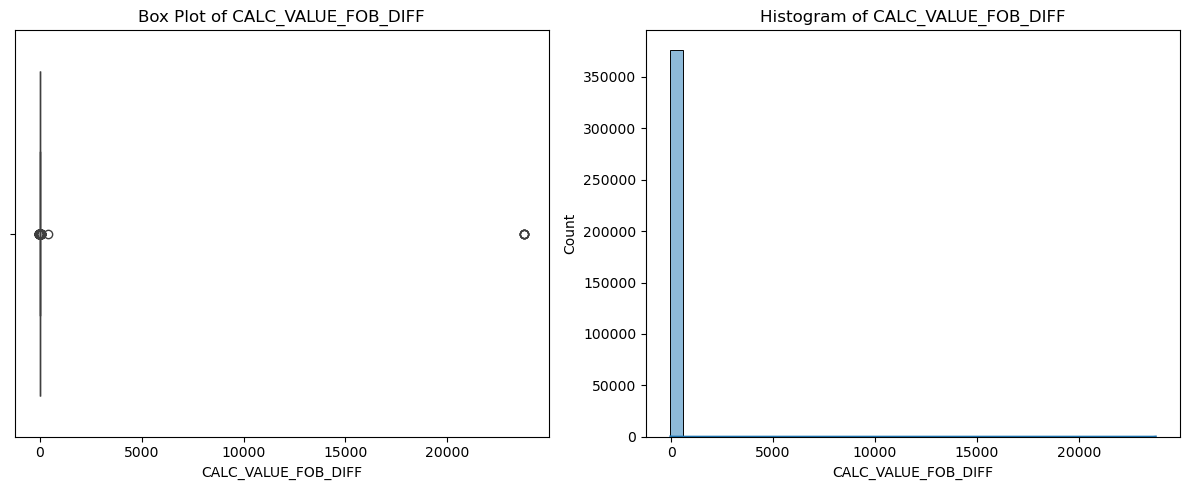

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['CALC_VALUE_FOB_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of CALC_VALUE_FOB_DIFF')

# Histogram
sns.histplot(combined["CALC_VALUE_FOB_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of CALC_VALUE_FOB_DIFF')

plt.tight_layout()
plt.show()

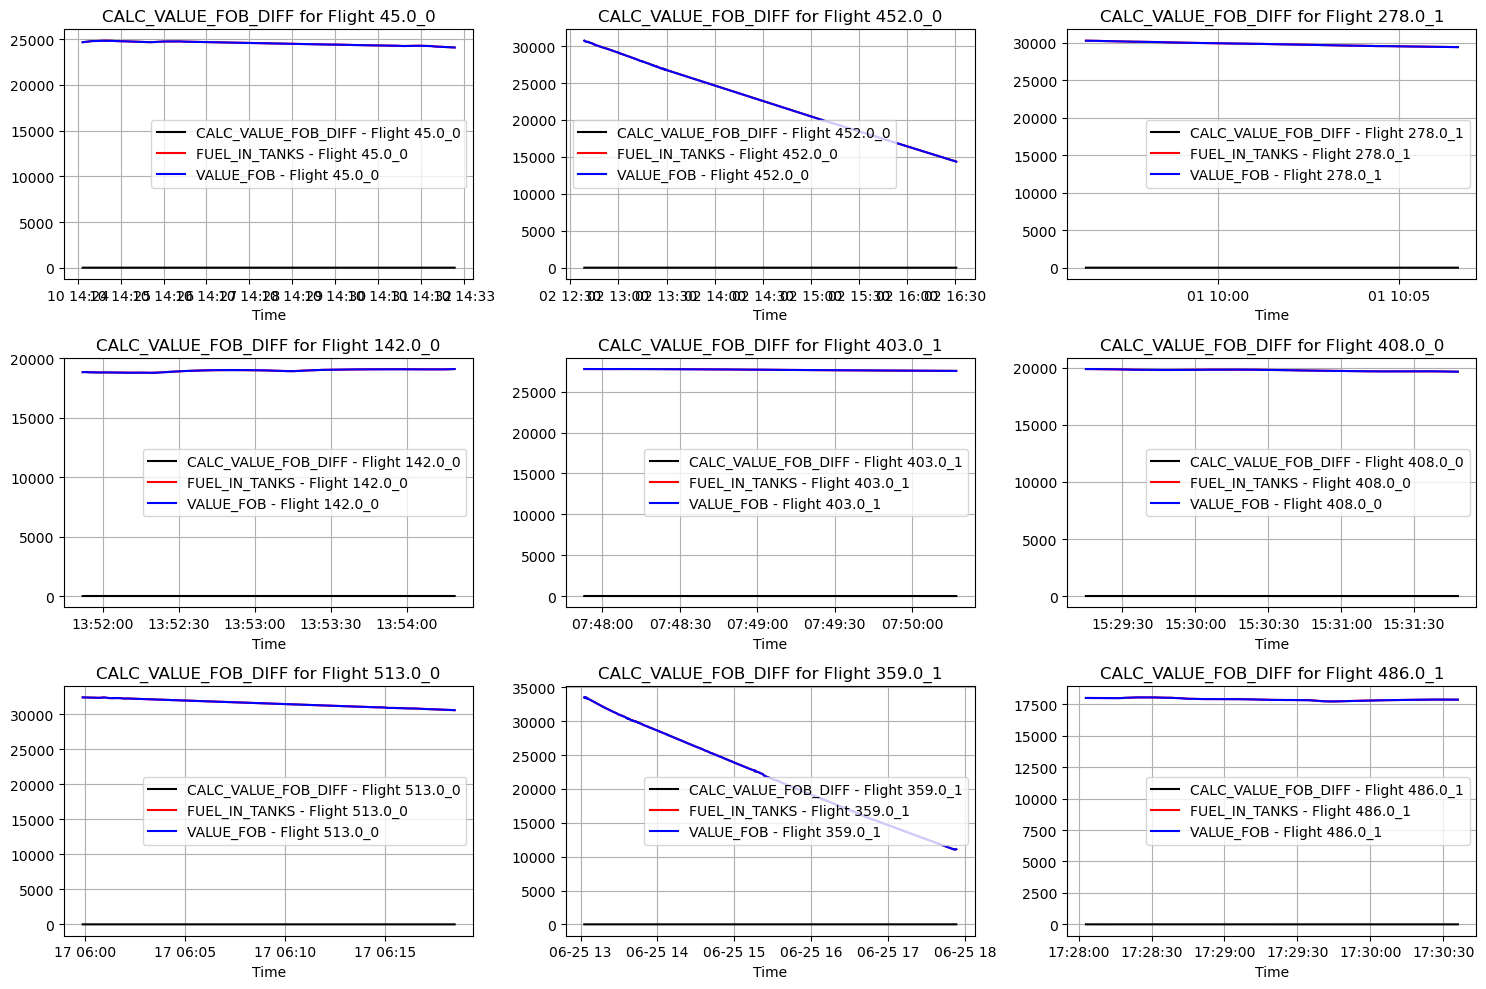

In [34]:
# Plotting CALC_VALUE_FOB_DIFF in Unique Fights
# =======================================
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    ax.plot(flight_data.index, flight_data['CALC_VALUE_FOB_DIFF'], label=f'CALC_VALUE_FOB_DIFF - Flight {flight}', color='black')
    ax.plot(flight_data.index, flight_data['FUEL_IN_TANKS'], label=f'FUEL_IN_TANKS - Flight {flight}', color='red')
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FOB - Flight {flight}', color='blue')

    ax.legend()
    
    ax.set_title(f'CALC_VALUE_FOB_DIFF for Flight {flight}')
    ax.set_xlabel('Time')
    
    ax.grid(True)

plt.tight_layout()

plt.show()

### `START_FOB_VS_FOB_FUELUSED`

In [35]:
combined['START_FOB_VS_FOB_FUELUSED'].describe()

count    376554.000000
mean      -2314.485906
std        2583.652119
min      -27859.418457
25%       -2801.845215
50%       -2108.913574
75%        -630.045273
max       39858.523926
Name: START_FOB_VS_FOB_FUELUSED, dtype: float64

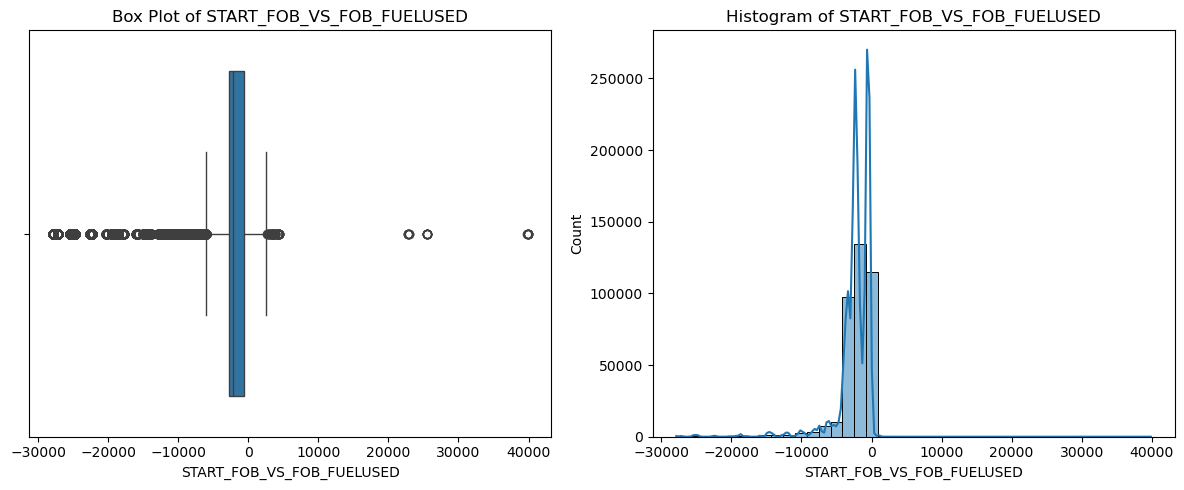

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['START_FOB_VS_FOB_FUELUSED'], ax=axes[0])
axes[0].set_title('Box Plot of START_FOB_VS_FOB_FUELUSED')

# Histogram
sns.histplot(combined["START_FOB_VS_FOB_FUELUSED"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of START_FOB_VS_FOB_FUELUSED')

plt.tight_layout()
plt.show()

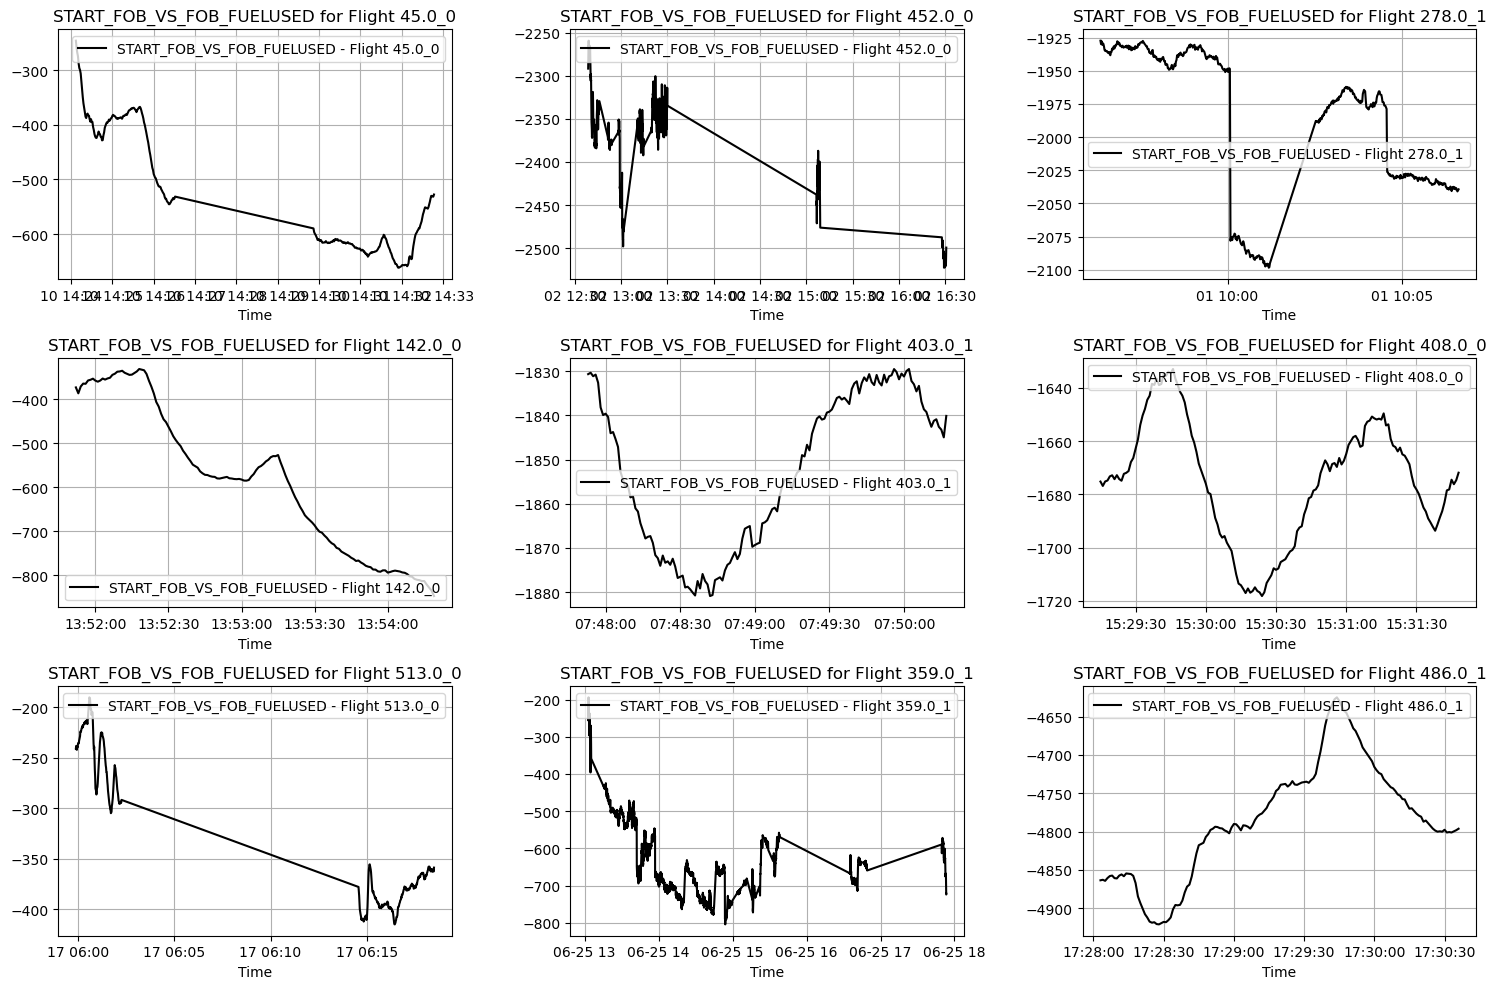

In [37]:
# Plotting START_FOB_VS_FOB_FUELUSED in Unique Fights
# =======================================
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    ax.plot(flight_data.index, flight_data['START_FOB_VS_FOB_FUELUSED'], label=f'START_FOB_VS_FOB_FUELUSED - Flight {flight}', color='black')

    ax.legend()
    
    ax.set_title(f'START_FOB_VS_FOB_FUELUSED for Flight {flight}')
    ax.set_xlabel('Time')
    
    ax.grid(True)

plt.tight_layout()

plt.show()

### Altitude Difference

In [38]:
combined['ALTITUDE_DIFF'].describe()

count    376554.000000
mean          0.084025
std        2142.814404
min      -35540.000000
25%          -2.000000
50%           1.000000
75%           7.000000
max       35542.000000
Name: ALTITUDE_DIFF, dtype: float64

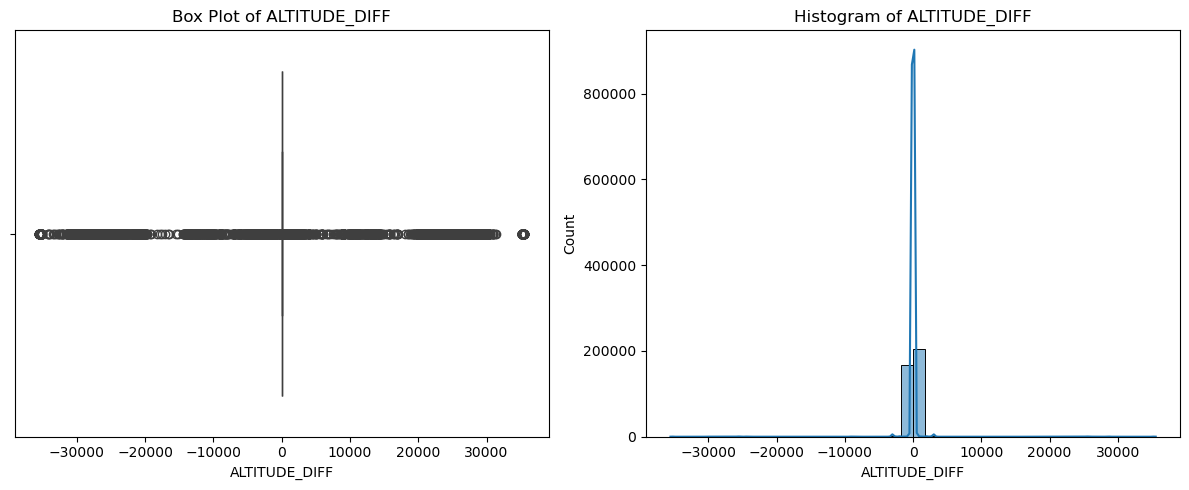

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['ALTITUDE_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of ALTITUDE_DIFF')

# Histogram
sns.histplot(combined["ALTITUDE_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of ALTITUDE_DIFF')

plt.tight_layout()
plt.show()

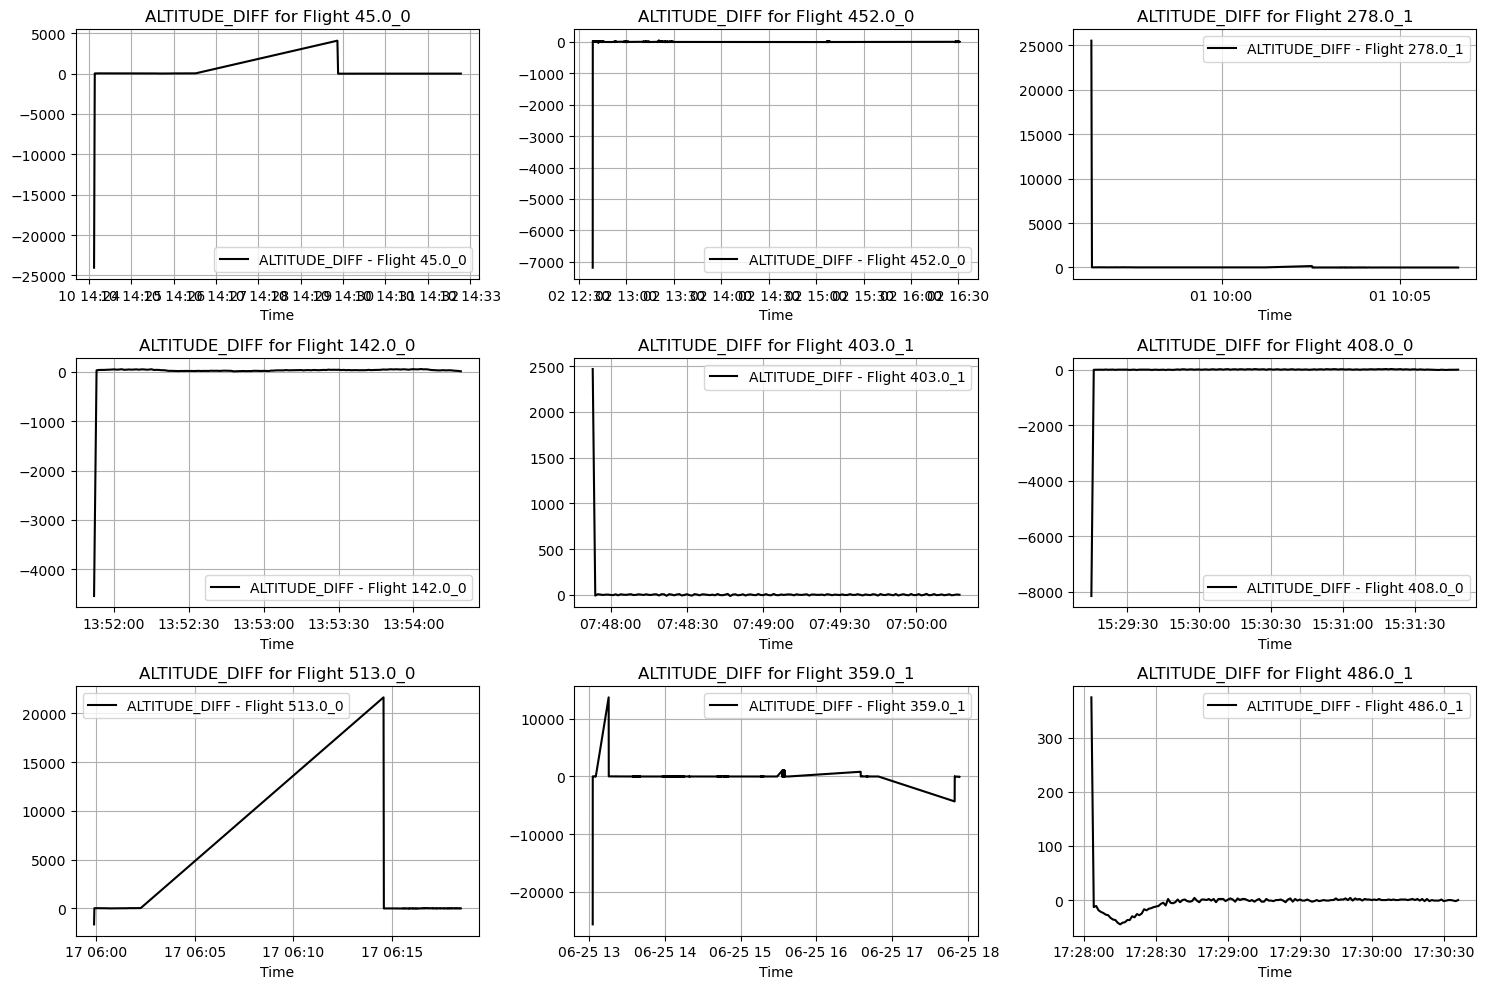

In [40]:
# Plotting ALTITUDE_DIFF in Unique Fights
# =======================================
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    ax.plot(flight_data.index, flight_data['ALTITUDE_DIFF'], label=f'ALTITUDE_DIFF - Flight {flight}', color='black')

    ax.legend()
    
    ax.set_title(f'ALTITUDE_DIFF for Flight {flight}')
    ax.set_xlabel('Time')
    
    ax.grid(True)

plt.tight_layout()

plt.show()

# Exporting to `combined.csv`

In [41]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376554 entries, 2015-07-21 03:51:31 to 2018-04-22 11:45:45
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   FUEL_USED_2                376554 non-null  float64
 1   FUEL_USED_3                376554 non-null  float64
 2   FUEL_USED_4                376554 non-null  float64
 3   FW_GEO_ALTITUDE            376554 non-null  float64
 4   VALUE_FOB                  376554 non-null  float64
 5   VALUE_FUEL_QTY_CT          376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1         376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2         376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3         376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4         376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT         376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT         376554 non-null  float64
 12  FLIGHT_PHASE_COUNT         376554 non-null  float64


In [42]:
# Save the DataFrame as a CSV
combined.to_csv("combined.csv")

In [43]:
combined.head()

,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,...,FOB_CHANGE,EXPECTED_FOB_CHANGE,FUEL_LEAK_RATE,TOTAL_FUEL_LW,TOTAL_FUEL_RW,LW_RW_DIFF,FUEL_IN_TANKS,CALC_VALUE_FOB_DIFF,START_FOB_VS_FOB_FUELUSED,ALTITUDE_DIFF
UTC_TIME,,,,,,,,,,,,,,,,,,,,,
2015-07-21 03:51:31,2454.501465,2444.412842,2481.687988,336.0,30967.0,0.0,1918.0,2620.0,2604.0,1920.0,...,0.0,0.000000,0.000000,15477.0,15491.0,14.0,30968.0,1.0,-9827.431152,0.0
2016-08-16 12:29:02,531.809998,528.252380,523.025574,29998.0,19135.0,0.0,1963.0,2624.0,2443.0,1775.0,...,-11832.0,7711.822815,19543.822815,9523.0,9612.0,89.0,19135.0,0.0,-2114.608337,29662.0
2016-08-16 12:29:03,532.141541,528.685181,523.363403,30010.0,19134.0,0.0,1966.0,2624.0,2442.0,1776.0,...,-1.0,-1.485291,-0.485291,9524.0,9612.0,88.0,19136.0,2.0,-2117.093628,12.0
2016-08-16 12:29:04,532.568909,529.068176,523.795654,30003.0,19136.0,0.0,1969.0,2624.0,2442.0,1776.0,...,2.0,-1.674683,-3.674683,9526.0,9614.0,88.0,19140.0,4.0,-2122.768311,-7.0
2016-08-16 12:29:05,532.947754,529.499207,524.179749,29989.0,19133.0,0.0,1972.0,2624.0,2440.0,1776.0,...,-3.0,-1.527893,1.472107,9526.0,9611.0,85.0,19137.0,4.0,-2121.296204,-14.0


# Simulating leaks

In [ ]:
def leak(df, threshold, probability, seed=42):
    np.random.seed(seed)  # Set seed for reproducibility
    df["LEAK_FLOW_FLAG"] = np.where(df["LW_RW_DIFF"] > threshold, 
                          np.random.choice([0, 1], size=len(df), p=[1-probability, probability]), 
                          0)  # No leak if condition is not met
    return df

combined_simulated = leak(combined, 350, 0.507)

In [ ]:
combined_simulated.head()

,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,...,EXPECTED_FOB_CHANGE,FUEL_LEAK_RATE,TOTAL_FUEL_LW,TOTAL_FUEL_RW,LW_RW_DIFF,FUEL_IN_TANKS,CALC_VALUE_FOB_DIFF,START_FOB_VS_FOB_FUELUSED,ALTITUDE_DIFF,LEAK_FLOW_FLAG
UTC_TIME,,,,,,,,,,,,,,,,,,,,,
2015-07-21 03:51:31,2454.501465,2444.412842,2481.687988,336.0,30967.0,0.0,1918.0,2620.0,2604.0,1920.0,...,0.000000,0.000000,15477.0,15491.0,14.0,30968.0,1.0,-9827.431152,0.0,0
2016-08-16 12:29:02,531.809998,528.252380,523.025574,29998.0,19135.0,0.0,1963.0,2624.0,2443.0,1775.0,...,7711.822815,19543.822815,9523.0,9612.0,89.0,19135.0,0.0,-2114.608337,29662.0,0
2016-08-16 12:29:03,532.141541,528.685181,523.363403,30010.0,19134.0,0.0,1966.0,2624.0,2442.0,1776.0,...,-1.485291,-0.485291,9524.0,9612.0,88.0,19136.0,2.0,-2117.093628,12.0,0
2016-08-16 12:29:04,532.568909,529.068176,523.795654,30003.0,19136.0,0.0,1969.0,2624.0,2442.0,1776.0,...,-1.674683,-3.674683,9526.0,9614.0,88.0,19140.0,4.0,-2122.768311,-7.0,0
2016-08-16 12:29:05,532.947754,529.499207,524.179749,29989.0,19133.0,0.0,1972.0,2624.0,2440.0,1776.0,...,-1.527893,1.472107,9526.0,9611.0,85.0,19137.0,4.0,-2121.296204,-14.0,0


In [ ]:
combined_simulated["LEAK_FLOW_FLAG"].value_counts(normalize=True) * 100

LEAK_FLOW_FLAG
0    91.110173
1     8.889827
Name: proportion, dtype: float64

In [ ]:
# Save the DataFrame as a CSV
combined_simulated.to_csv("combined_simulated.csv")

In [51]:
combined_simulated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376554 entries, 2015-07-21 03:51:31 to 2018-04-22 11:45:45
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   FUEL_USED_2                376554 non-null  float64
 1   FUEL_USED_3                376554 non-null  float64
 2   FUEL_USED_4                376554 non-null  float64
 3   FW_GEO_ALTITUDE            376554 non-null  float64
 4   VALUE_FOB                  376554 non-null  float64
 5   VALUE_FUEL_QTY_CT          376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1         376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2         376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3         376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4         376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT         376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT         376554 non-null  float64
 12  FLIGHT_PHASE_COUNT         376554 non-null  float64


In [52]:
combined_simulated['LEAK_FLOW_FLAG'].value_counts()

LEAK_FLOW_FLAG
0    343079
1     33475
Name: count, dtype: int64